### This notebook will investigate the following question:
#### Q: Compare satellite vs GSM vs DME vs unknown contributions to RFI - relative importance


In [2]:
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
rcParams['figure.figsize'] = (11.7,8.27)
rcParams['font.size']=13
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import time
import numpy as np
import pandas as pd
import xarray as xr
import dask.array as da
from dask import compute
from dask import config
import seaborn as sns
sns.set()
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (18, 12),
         'axes.labelsize': 18,
         'axes.titlesize':18,
         'xtick.labelsize':18,
         'ytick.labelsize':18,
         'axes.labelweight':'bold',
          'legend.fontsize': 18}
         
plt.rcParams.update(params)
#plt.matplotlib.rc('font', **font)
plt.style.use('default')

In [4]:
# Path to the DR0 and DR1 data-set
FileName1 = '/data/isaac/DR0/Single_obsDR0/DR0Full2.zarr/'
FileName2 = '/data/isaac/DR1/fullDR1.zarr'
# Loading the data
MyData1 = xr.open_zarr(FileName1)
MyData2 = xr.open_zarr(FileName2)
# Combining two dataset
data = MyData1+MyData2

In [5]:
# Extracting frequencies (MHz)
freq = data.frequency.values/1e6

In [6]:
# Extracting the Master and the Counter array
MyMaster = data.master.astype(float)
MyCounter =data.counter.astype(float)

## Plots of the overall Results

### Direction

In [7]:
# Azimuth
AzMaster = MyMaster.sum(dim = ['frequency','time','baseline','elevation']) 
AzCounter = MyCounter.sum(dim = ['frequency','time','baseline','elevation'])
AzProb = AzMaster.astype(float)/AzCounter.astype(float)
AzProb = AzProb.persist()

In [8]:
# Elevation and azimuth
FreqMaster = MyMaster.sum(dim = ['time','frequency','baseline']) 
FreqCounter = MyCounter.sum(dim = ['time','frequency','baseline'])
ElAzProb = FreqMaster.astype(float)/FreqCounter.astype(float)
ElAzProb = ElAzProb.persist()

/home/isaac/.local/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


In [9]:
# Elevation
ElMaster = MyMaster.sum(dim = ['frequency','time','baseline','azimuth']) 
ElCounter = MyCounter.sum(dim = ['frequency','time','baseline','azimuth'])
ElProb = ElMaster.astype(float)/ElCounter.astype(float)
ElProb = ElProb.persist()

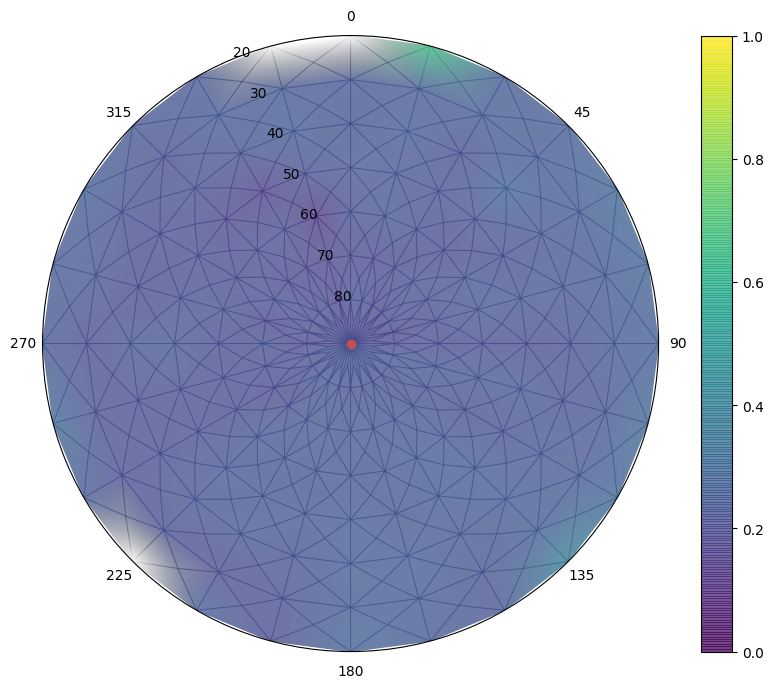

In [59]:
from scipy.interpolate import griddata
import matplotlib

# theta = np.deg2rad(AzProb.azimuth.values)
theta = np.deg2rad(np.arange(0,370,15))# + 7.5)
#r = 90.-ElProb.elevation.values
r = 80.-ElProb.elevation.values #- 5.0

#grid_r, grid_theta = np.meshgrid(r, theta)
#data = griddata(points, values, (grid_r, grid_theta))#, method='cubic')
Mydata = ElAzProb.values

# Adding the the last item to interpolate
MyNewData = np.concatenate((Mydata, Mydata[:,0,None]), axis=1)

#print("Data shape",MyNewData.shape)

#Create a polar projection
plt.figure(figsize=(11,8))

ax1 = plt.subplot(projection="polar")


#cmap = ax1.pcolormesh(-theta,r,data,alpha = 0.5)#, shading='gouraud')
cmap = ax1.pcolormesh(-theta,r,MyNewData,alpha = 0.75, shading='gouraud',vmin=0,vmax=1)#,norm=matplotlib.colors.PowerNorm(),cmap='PuOr')
ax1.set_yticklabels(np.arange(80,10,-10))

OwnLabel = [0,315,270,225,180,135,90,45]
ax1.set_xticklabels(OwnLabel)
ax1.set_theta_zero_location('N')
ax1.plot(0,0,'ro')
plt.colorbar(cmap)
#plt.colorbar('PuBu_r')
#ax1.set_rlim(10)
#ax1.set_rscale('log')

plt.show()

### Time and Frequency

In [11]:
MyMeanTimeMaster = MyMaster.sum(dim = ['frequency','baseline','elevation','azimuth']) 
MyMeanTimeCounter = MyCounter.sum(dim = ['frequency','baseline','elevation','azimuth'])
MyMeanTimeProb = MyMeanTimeMaster.astype(float)/MyMeanTimeCounter.astype(float)
MyMeanTimeProb = MyMeanTimeProb.persist()

In [12]:
MyMeanFreqMaster = MyMaster.sum(dim = ['time','baseline','elevation','azimuth']) 
MyMeanFreqCounter = MyCounter.sum(dim = ['time','baseline','elevation','azimuth'])
MyMeanFreqProb = MyMeanFreqMaster.astype(float)/MyMeanFreqCounter.astype(float)
MyMeanFreqProb = MyMeanFreqProb.persist()

In [13]:
TimeFreqMaster = MyMaster.sum(dim = ['azimuth','baseline','elevation']) 
TimeFreqCounter = MyCounter.sum(dim = ['azimuth','baseline','elevation'])
MyMeanTimeFreqProb = TimeFreqMaster.astype(float)/TimeFreqCounter.astype(float)
MyMeanTimeFreqProb = MyMeanTimeFreqProb.persist()

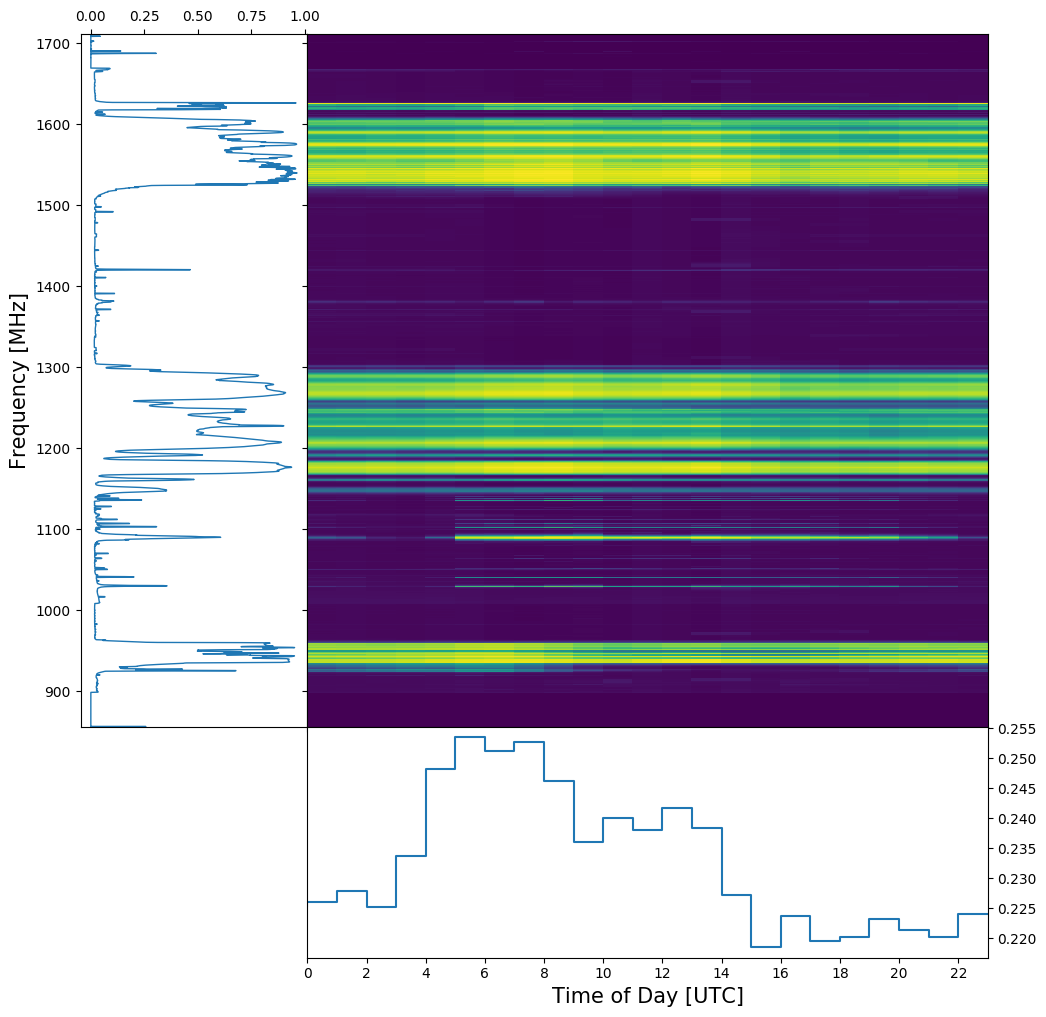

In [62]:
plt.figure(figsize=(12,12))

gs = gridspec.GridSpec(2, 3, width_ratios=[1,3,0.1], height_ratios=[3,1])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
#ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[4])

ax1.plot(MyMeanFreqProb.data, MyMeanFreqProb.frequency.frequency.values/1e6,lw=1.0)
ax1.xaxis.tick_top()
#ax1.set_ylim(MyMeanFreqProb.frequency.frequency.values[0],MyMeanFreqProb.frequency.frequency[-1])
ax1.set_ylim(freq[0],freq[-1])
ax1.set_ylabel('Frequency [MHz]', fontsize=15)

pc = ax2.pcolormesh( MyMeanTimeProb.time, MyMeanFreqProb.frequency, MyMeanTimeFreqProb.data.T,cmap='viridis')#, vmin=0.0)#, vmax=4.5)
ax2.set_xlim(MyMeanTimeProb.time.data[0], MyMeanTimeProb.time.data[-1])
ax2.set_ylim(MyMeanFreqProb.frequency.data[0], MyMeanFreqProb.frequency.data[-1])
ax2.set_xticklabels('')
ax2.set_yticklabels('')

#plt.colorbar(pc,ax=ax3)
#ax3.set_xticklabels('')
#ax3.set_yticklabels('')

ax4.step(MyMeanTimeProb.time.data, MyMeanTimeProb, '-')#where='post')
ax4.yaxis.tick_right()
ax4.set_xlim(0,23)
#ax3.set_xticks(4*np.arange(6), ["00H00", "04H00", "08H00", "12H00", "16H00", "20H00", "24H00"])
ax4.set_xticks(np.arange(0,23,step=2))
               
ax4.set_xlabel('Time of Day [UTC]', fontsize=15)

plt.subplots_adjust(wspace=0.0, hspace=0.0)
plt.savefig('HH'+'.png')
#plt.suptitle('HH Pol')
plt.show()


### Elevation and azimuth

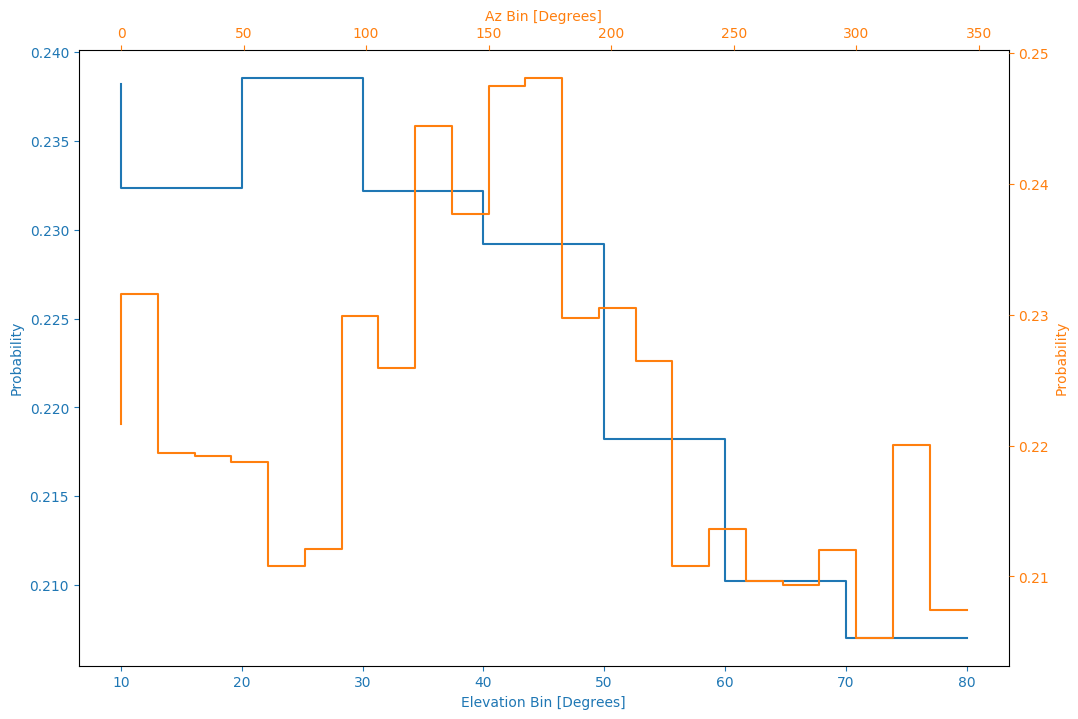

In [15]:
fig=plt.figure(figsize = (12,8))

ax=fig.add_subplot(111, label="1")

ax.step(ElProb.elevation.data,ElProb.data)
ax.set_xlabel('Elevation Bin [Degrees]', color="C0")
ax.set_ylabel('Probability', color="C0")
ax.tick_params(axis='x', colors="C0")
ax.tick_params(axis='y', colors="C0")

ax2=fig.add_subplot(111, label="2", frame_on=False)

ax2.step(AzProb.azimuth.data,AzProb.data,color="C1")
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlabel('Az Bin [Degrees]', color="C1") 
ax2.set_ylabel('Probability', color="C1")       
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='x', colors="C1")
ax2.tick_params(axis='y', colors="C1")
plt.show()

#### Ploting fucnction

In [16]:
def MyPLot(AzProb,ElProb,Mydata):
    
    print(Mydata.shape)
    theta = np.deg2rad(np.arange(0,370,15)) #+ 7.5)
    #r = 90.-ElProb.elevation.values
    r = 80.-ElProb.elevation.values# - 5.0
    #data = ElAzProb.values
    MyNewData = np.append(Mydata.values,Mydata.values[:,0][:,None],axis=1)
    #print(data.shape,r.shape, theta.shape)

    #Create a polar projection
    plt.figure(figsize=(11,8))
    #plt.gca().invert_yaxis()

    ax1 = plt.subplot(projection="polar")

    cmap = ax1.pcolormesh(-theta,r,MyNewData,alpha = 0.75,shading='gouraud',vmin=0,vmax=1)
    ax1.set_yticklabels(np.arange(80,10,-10))

    OwnLabel = [0,315,270,225,180,135,90,45]
    ax1.set_xticklabels(OwnLabel)
    ax1.set_theta_zero_location('N')

    plt.colorbar(cmap)
    plt.show()
    return()

In [17]:
start = [890,935,1710,962,1025,1151,1567,1222,1375,1375,1170]
end =[915,960,1785,1024,1150,1213,1582,1232,1385,1384,1182]
name =  ['gsm900 uplink','gsm900 downlink','gsm1800 uplink','dmeG2A1','dmeA2G','dmeG2A2','L1','L2','L3','L4','L5']

In [18]:
def plot(s,e,MyMaster,MyCounter,name):
    idx1 = np.where((freq>=s) & (freq<=e))[0]
    tm = MyMaster[:,idx1].sum(dim=['frequency','baseline','azimuth','elevation'])
    tc = MyCounter[:,idx1].sum(dim=['frequency','baseline','azimuth','elevation'])
    p = tm.astype(float)/tc.astype(float)
    p = p.values

    plt.figure(figsize=(12,8))
    plt.step(np.arange(p.shape[0]),p,label='Average RFI',linewidth=5)
    #plt.fill_between(np.arange(p.shape[0]), er68[0], er68[1],color='g',alpha=0.3,label=str(con68)+'% Confidence interval')
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
    plt.xlabel('Time [UTC]',fontsize=20)
    plt.ylabel('Probability',fontsize=20)
    plt.title(name)
    plt.grid()
    plt.show()

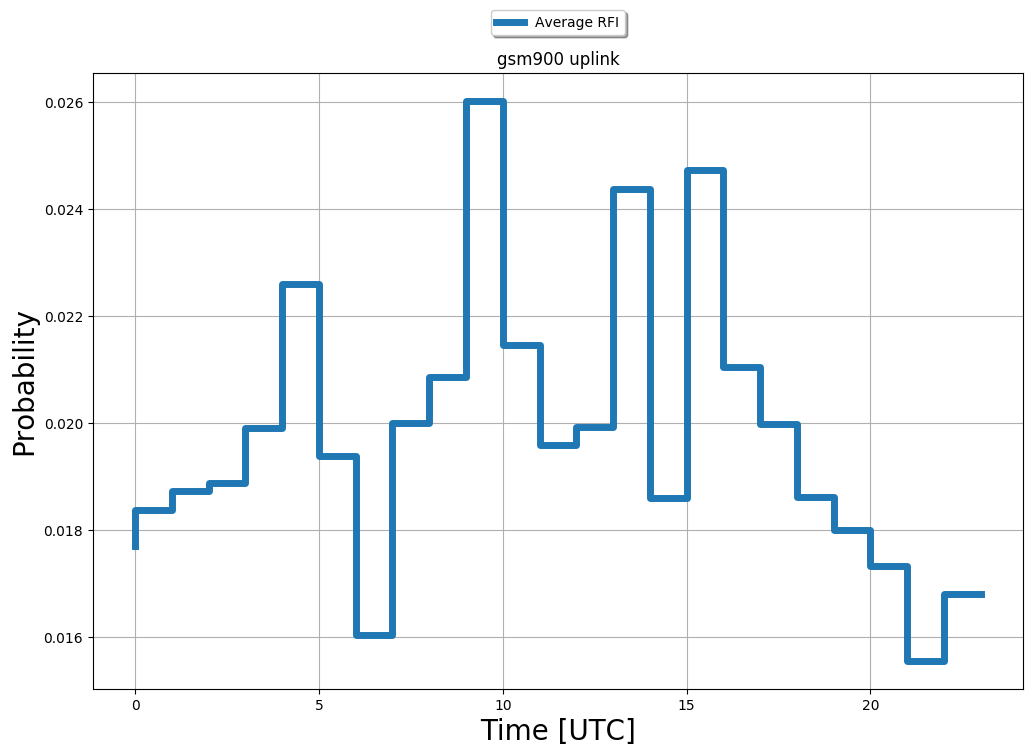

In [19]:
plot(start[0],end[0],MyMaster,MyCounter,name[0])

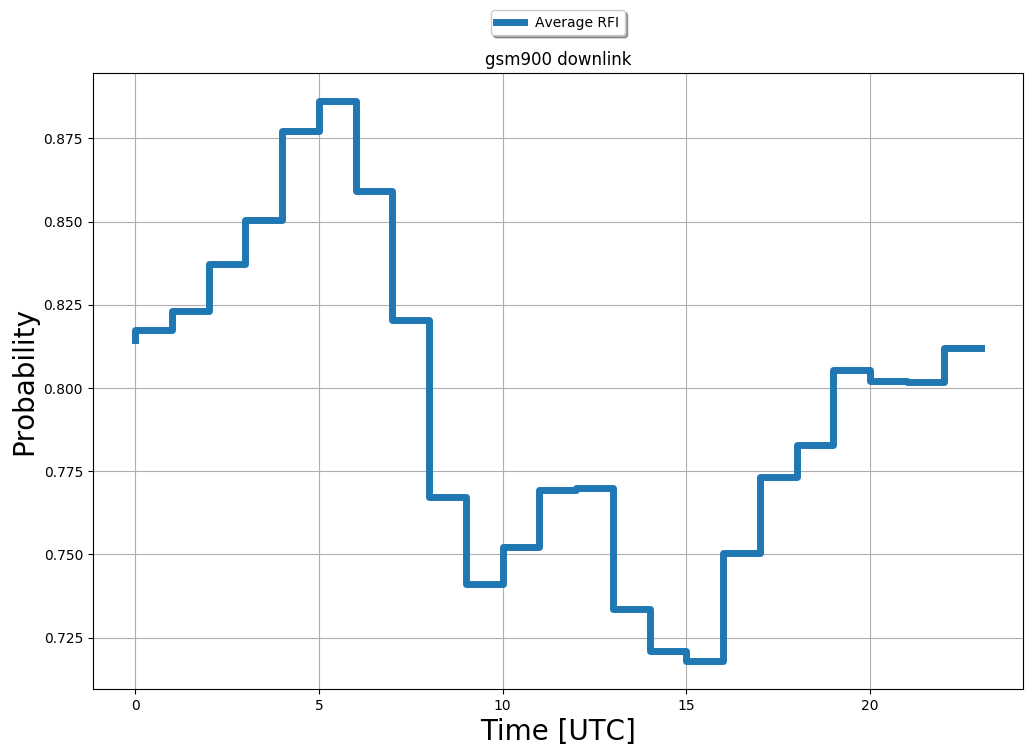

In [20]:
plot(start[1],end[1],MyMaster,MyCounter,name[1])

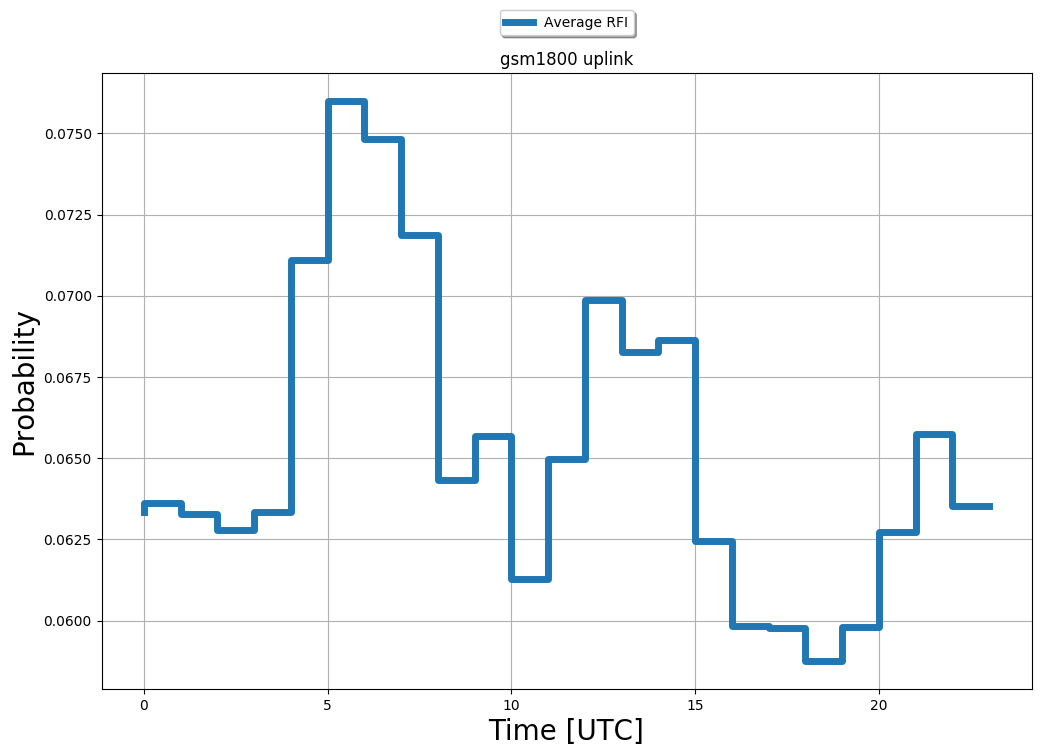

In [21]:
plot(start[2],end[2],MyMaster,MyCounter,name[2])

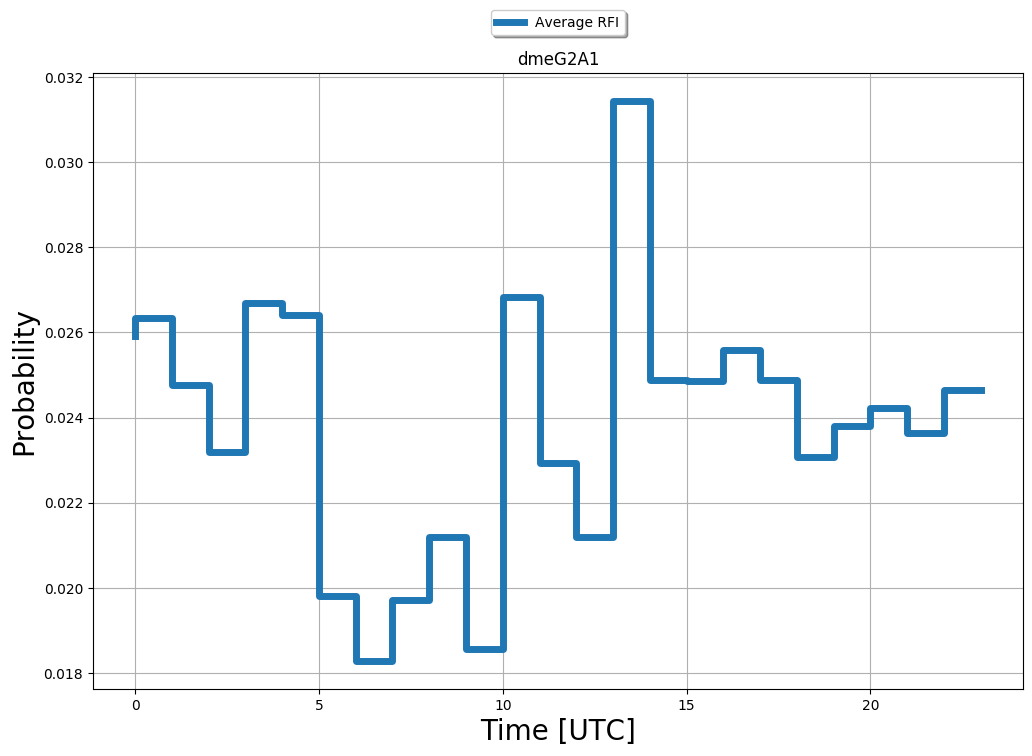

In [22]:
plot(start[3],end[3],MyMaster,MyCounter,name[3])

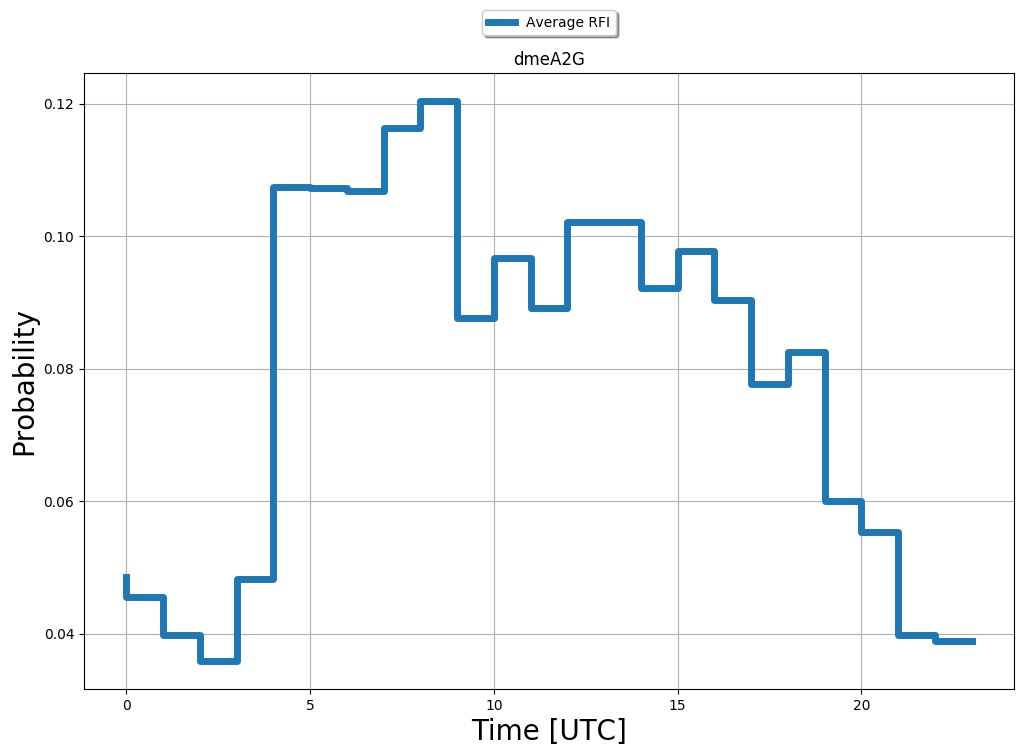

In [23]:
plot(start[4],end[4],MyMaster,MyCounter,name[4])

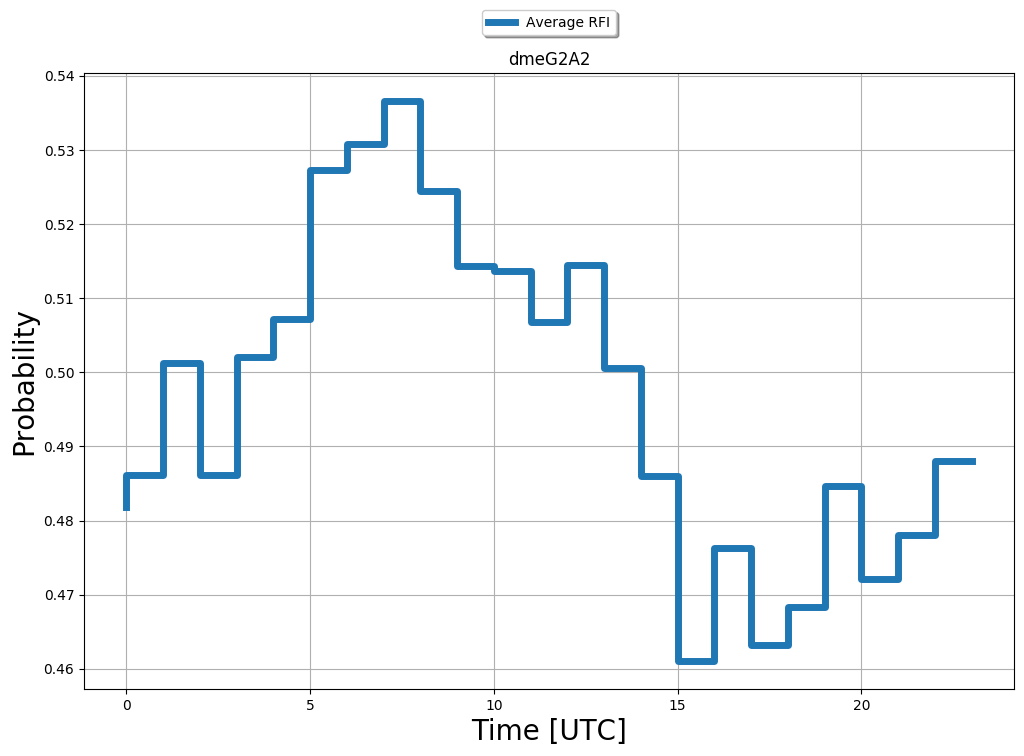

In [24]:
plot(start[5],end[5],MyMaster,MyCounter,name[5])

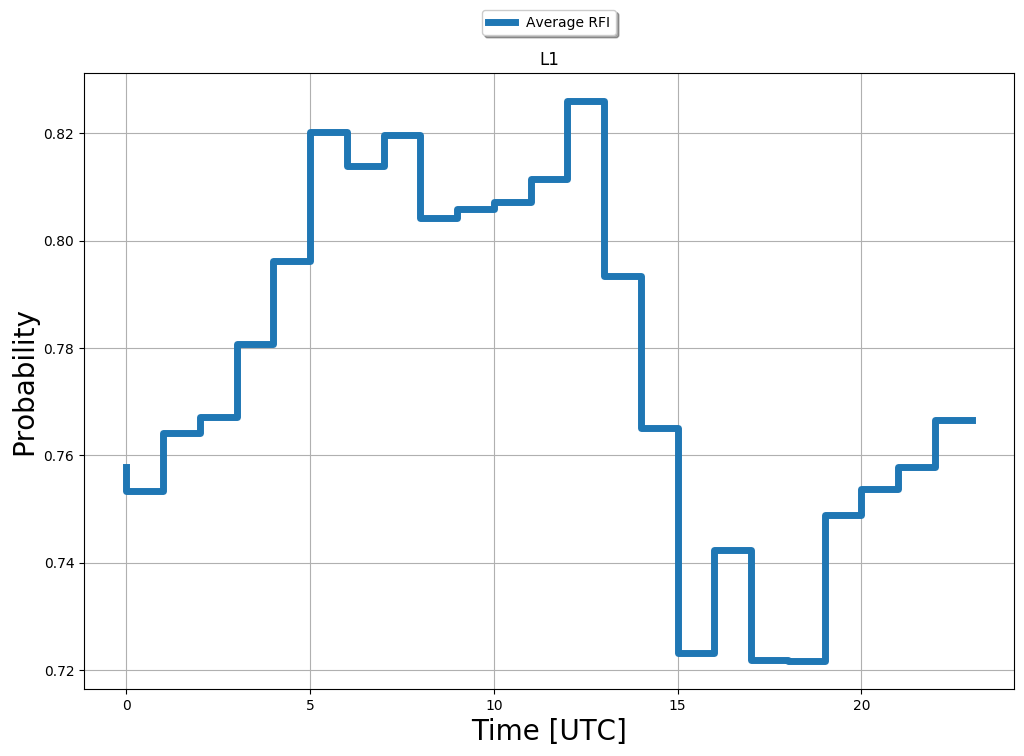

In [25]:
plot(start[6],end[6],MyMaster,MyCounter,name[6])

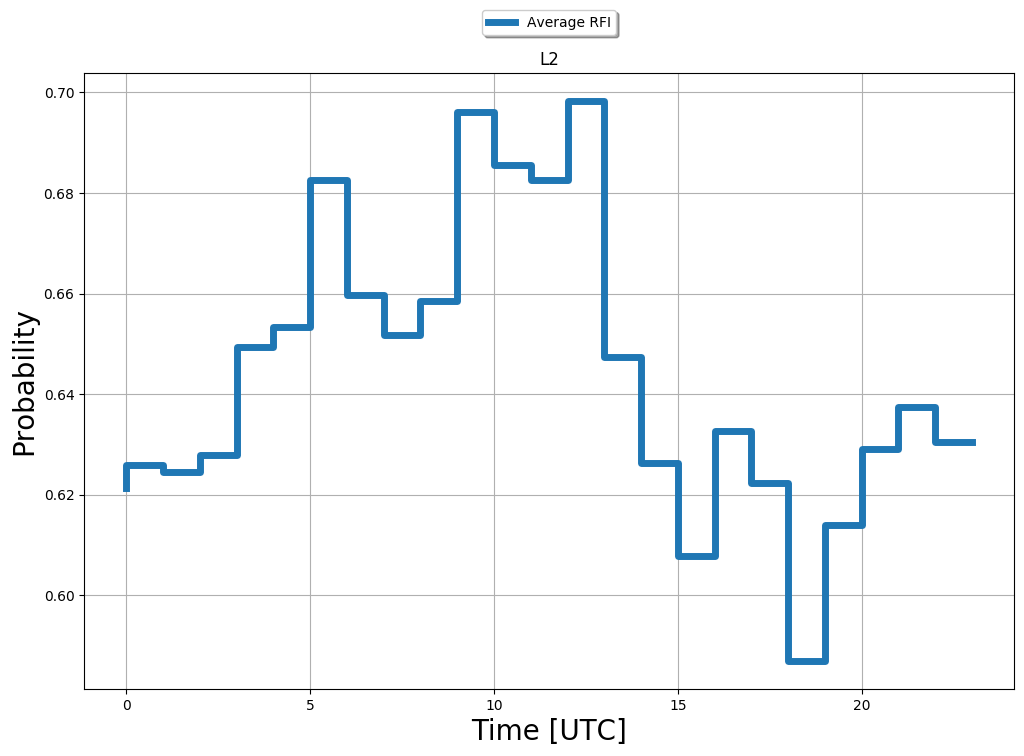

In [26]:
plot(start[7],end[7],MyMaster,MyCounter,name[7])

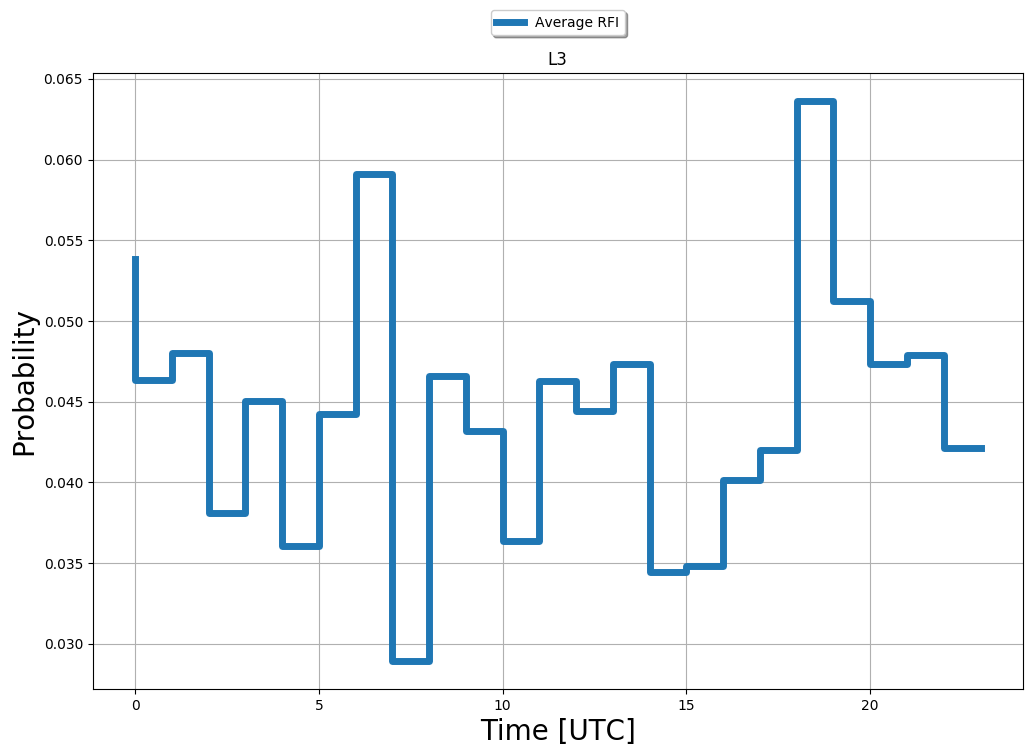

In [27]:
plot(start[8],end[8],MyMaster,MyCounter,name[8])

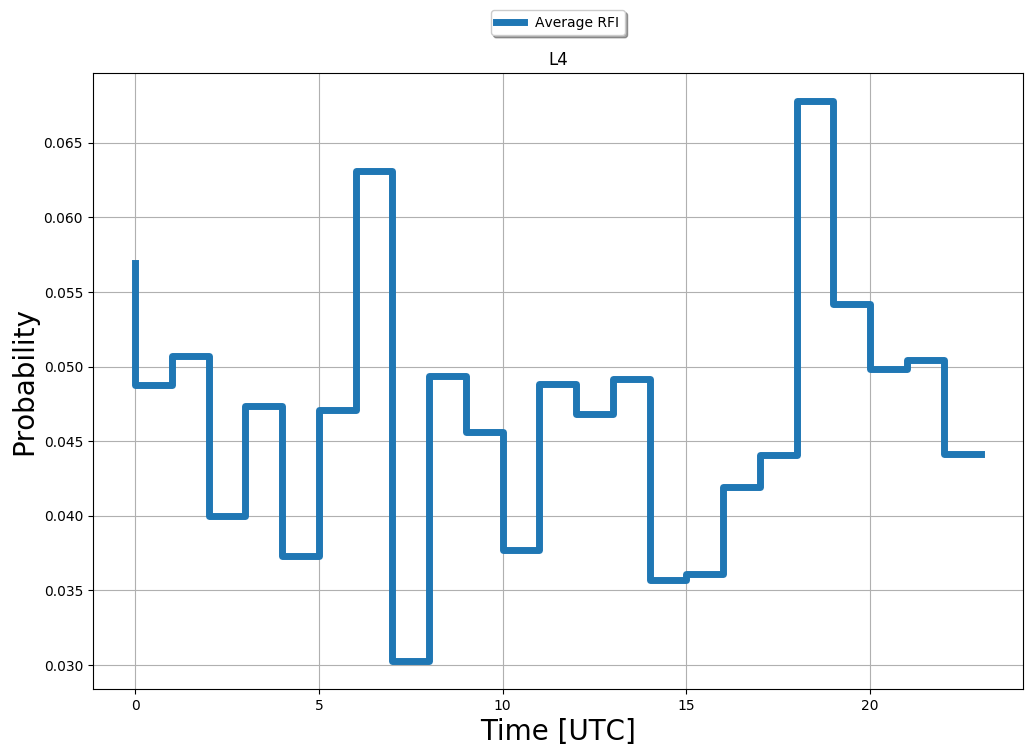

In [28]:
plot(start[9],end[9],MyMaster,MyCounter,name[9])

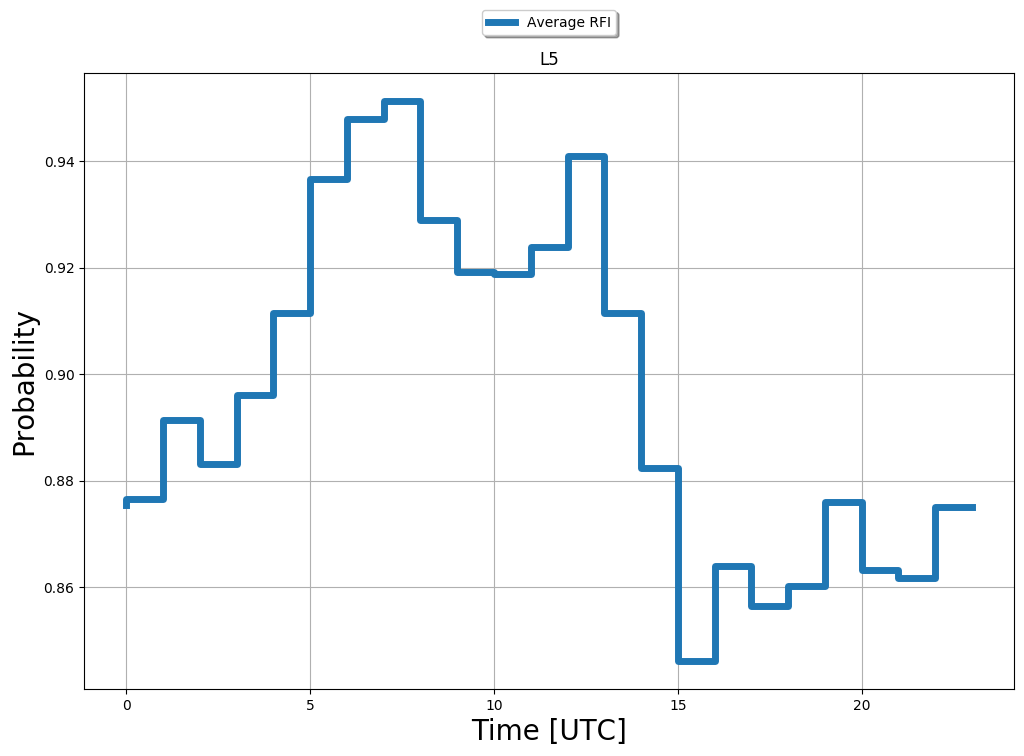

In [29]:
plot(start[10],end[10],MyMaster,MyCounter,name[10])

## GSM Anaysis

### Time Analysis

### Direction Analysis

/home/isaac/.local/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


(8, 24)


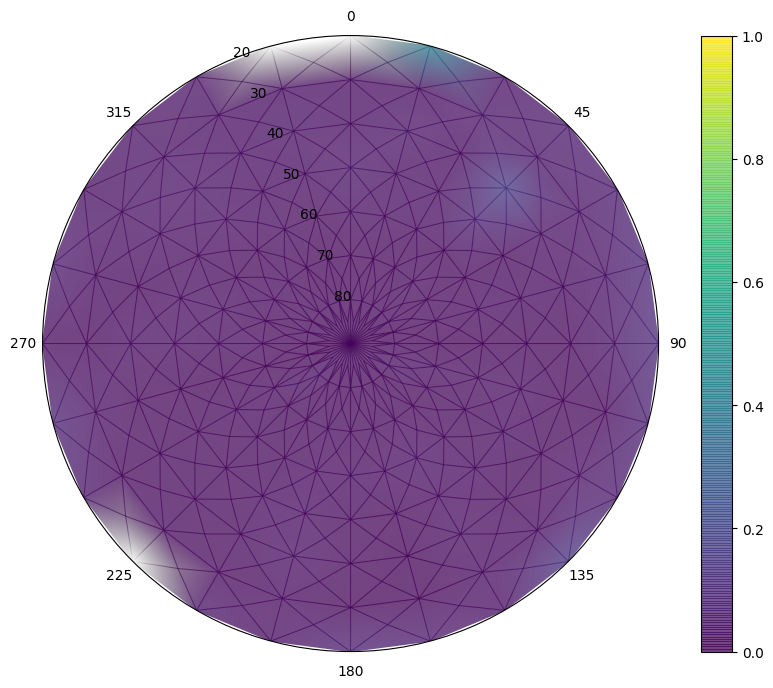

In [30]:
# GSM-900 Uplink uses 890 - 915 MHz
FreqLo = 890.
FreqHi = 915.
ChanIndx = np.where((MyMeanFreqProb.frequency.frequency >= FreqLo*1.e6) & 
                    (MyMeanFreqProb.frequency.frequency <= FreqHi*1.e6))[0]

if len(ChanIndx) != 0:
    SpecMaster = MyMaster.sum(dim = ['time','baseline'])
    SpecMaster = SpecMaster[ChanIndx].sum(dim = ['frequency'])

    SpecCounter = MyCounter.sum(dim = ['time','baseline'])
    SpecCounter = SpecCounter[ChanIndx].sum(dim = ['frequency'])

    SpecProb = SpecMaster.astype(float)/SpecCounter.astype(float)
    SpecProb = SpecProb.persist()

    Mydata = SpecProb
    
    MyPLot(AzProb,ElProb,Mydata)
else:
    print("Something went wrong in Frequency selection")
    

/home/isaac/.local/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


(8, 24)


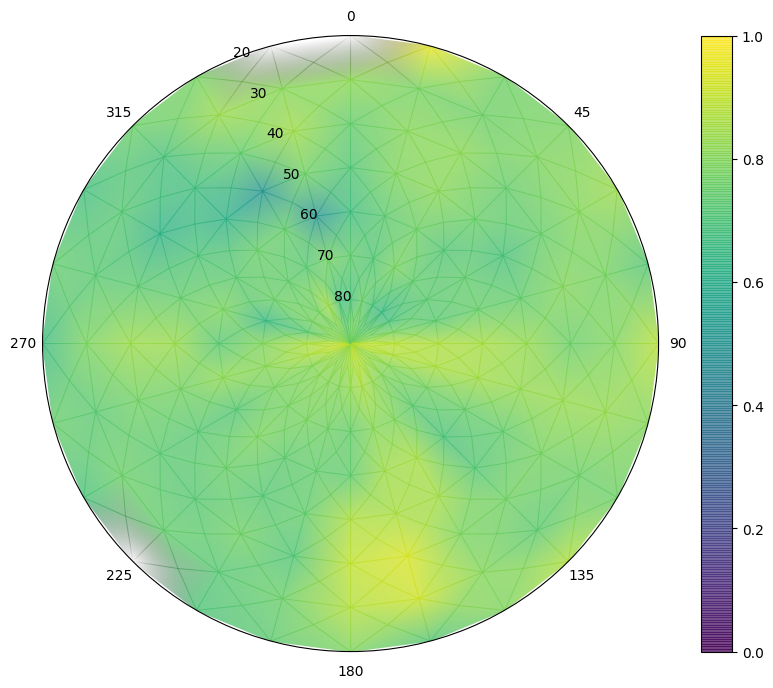

In [31]:
# GSM-900 Downlink uses 890 - 915 MHz
FreqLo = 935.
FreqHi = 960.
ChanIndx = np.where((MyMeanFreqProb.frequency.frequency >= FreqLo*1.e6) & 
                    (MyMeanFreqProb.frequency.frequency <= FreqHi*1.e6))[0]

if len(ChanIndx) != 0:


    SpecMaster = MyMaster.sum(dim = ['time','baseline'])
    SpecMaster = SpecMaster[ChanIndx].sum(dim = ['frequency'])

    SpecCounter = MyCounter.sum(dim = ['time','baseline'])
    SpecCounter = SpecCounter[ChanIndx].sum(dim = ['frequency'])

    SpecProb = SpecMaster.astype(float)/SpecCounter.astype(float)
    SpecProb = SpecProb.persist()

    Mydata = SpecProb
    
    MyPLot(AzProb,ElProb,Mydata)
else:
    print("Something went wrong in Frequency selection")

/home/isaac/.local/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


(8, 24)


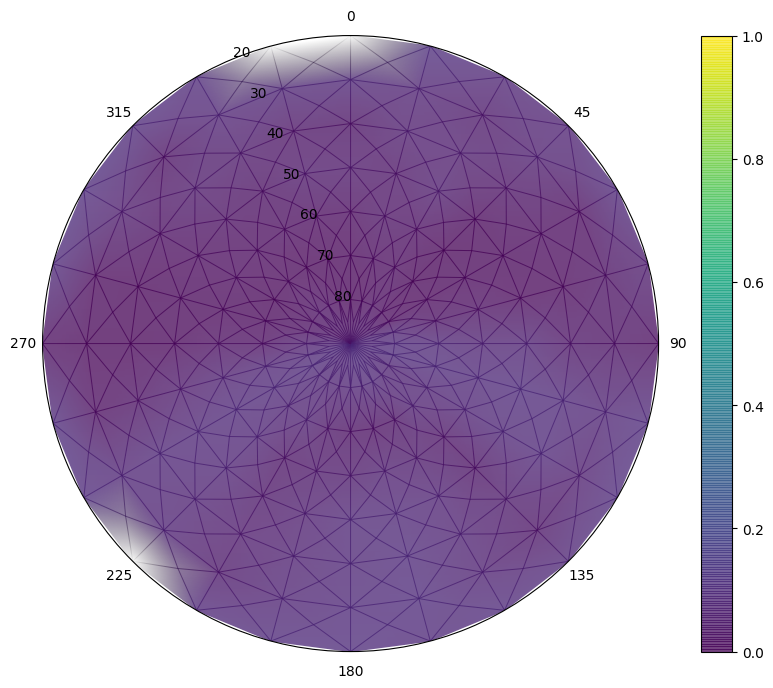

In [32]:
# GSM-1800 Uplink uses 1710 - 1785 MHz
FreqLo = 1710.
FreqHi = 1785.
ChanIndx = np.where((MyMeanFreqProb.frequency.frequency >= FreqLo*1.e6) & 
                    (MyMeanFreqProb.frequency.frequency <= FreqHi*1.e6))[0]

if len(ChanIndx) != 0:


    SpecMaster = MyMaster.sum(dim = ['time','baseline'])
    SpecMaster = SpecMaster[ChanIndx].sum(dim = ['frequency'])

    SpecCounter = MyCounter.sum(dim = ['time','baseline'])
    SpecCounter = SpecCounter[ChanIndx].sum(dim = ['frequency'])

    SpecProb = SpecMaster.astype(float)/SpecCounter.astype(float)
    SpecProb = SpecProb.persist()

    Mydata = SpecProb
    
    MyPLot(AzProb,ElProb,Mydata)
else:
    print("Something went wrong in Frequency selection")


## DME selection 

### Dircetion

/home/isaac/.local/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


(8, 24)


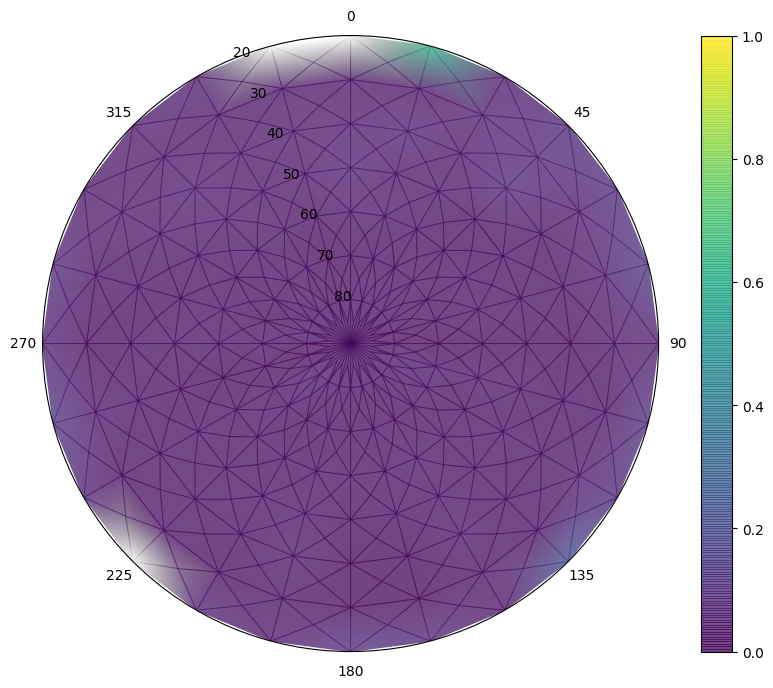

In [33]:
FreqLo = 962
FreqHi = 1024

ChanIndx = np.where((MyMeanFreqProb.frequency.frequency >= FreqLo*1.e6) & 
                    (MyMeanFreqProb.frequency.frequency <= FreqHi*1.e6))[0]

if len(ChanIndx) != 0:


    SpecMaster = MyMaster.sum(dim = ['time','baseline'])
    SpecMaster = SpecMaster[ChanIndx].sum(dim = ['frequency'])

    SpecCounter = MyCounter.sum(dim = ['time','baseline'])
    SpecCounter = SpecCounter[ChanIndx].sum(dim = ['frequency'])

    SpecProb = SpecMaster.astype(float)/SpecCounter.astype(float)
    SpecProb = SpecProb.persist()

    Mydata = SpecProb
    
    MyPLot(AzProb,ElProb,Mydata)
else:
    print("Something went wrong in Frequency selection")
    

/home/isaac/.local/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


(8, 24)


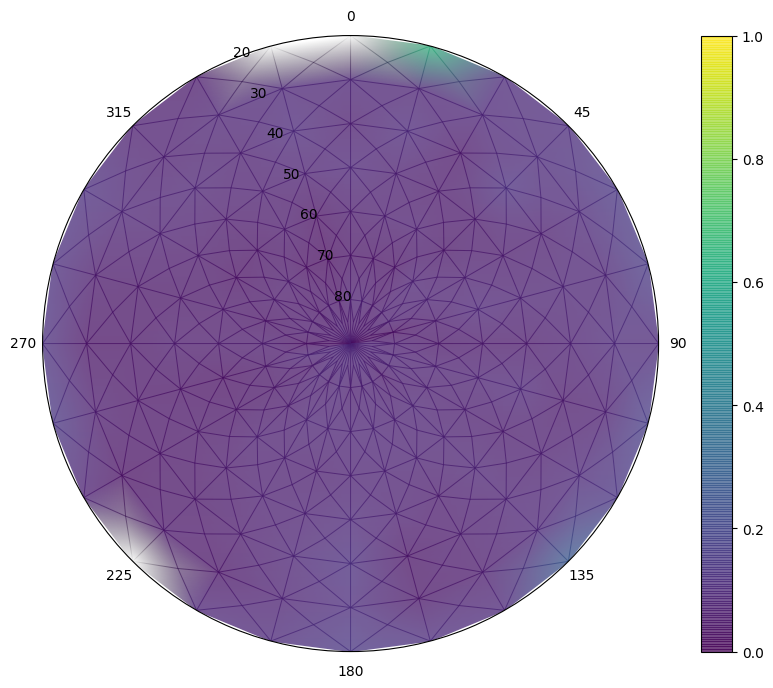

In [34]:
FreqLo =  1025
FreqHi = 1150

ChanIndx = np.where((MyMeanFreqProb.frequency.frequency >= FreqLo*1.e6) & 
                    (MyMeanFreqProb.frequency.frequency <= FreqHi*1.e6))[0]

if len(ChanIndx) != 0:


    SpecMaster = MyMaster.sum(dim = ['time','baseline'])
    SpecMaster = SpecMaster[ChanIndx].sum(dim = ['frequency'])

    SpecCounter = MyCounter.sum(dim = ['time','baseline'])
    SpecCounter = SpecCounter[ChanIndx].sum(dim = ['frequency'])

    SpecProb = SpecMaster.astype(float)/SpecCounter.astype(float)
    SpecProb = SpecProb.persist()

    Mydata = SpecProb
    
    MyPLot(AzProb,ElProb,Mydata)
else:
    print("Something went wrong in Frequency selection")
    
    

/home/isaac/.local/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


(8, 24)


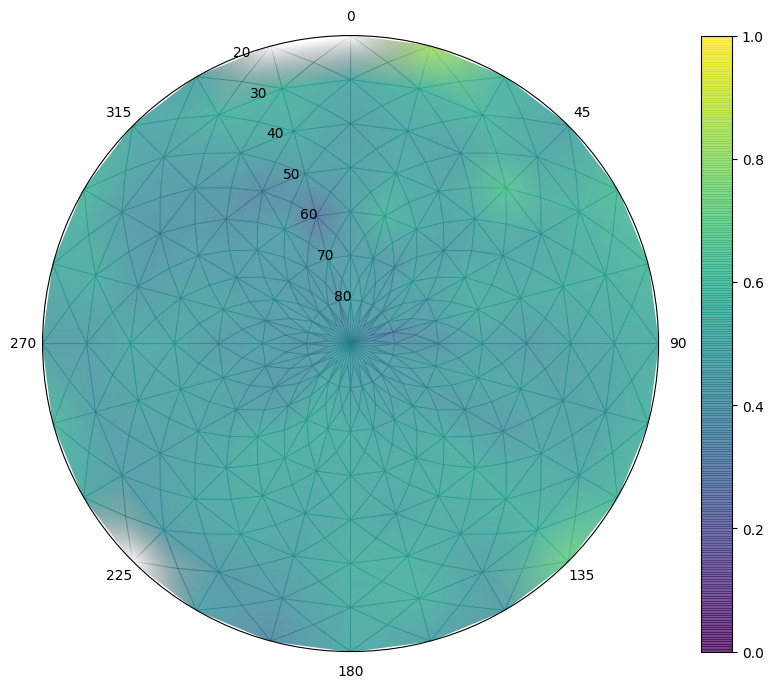

In [35]:
FreqLo = 1151
FreqHi = 1213

ChanIndx = np.where((MyMeanFreqProb.frequency.frequency >= FreqLo*1.e6) & 
                    (MyMeanFreqProb.frequency.frequency <= FreqHi*1.e6))[0]
if len(ChanIndx) != 0:


    SpecMaster = MyMaster.sum(dim = ['time','baseline'])
    SpecMaster = SpecMaster[ChanIndx].sum(dim = ['frequency'])

    SpecCounter = MyCounter.sum(dim = ['time','baseline'])
    SpecCounter = SpecCounter[ChanIndx].sum(dim = ['frequency'])

    SpecProb = SpecMaster.astype(float)/SpecCounter.astype(float)
    SpecProb = SpecProb.persist()

    Mydata = SpecProb
    
    MyPLot(AzProb,ElProb,Mydata)
else:
    print("Something went wrong in Frequency selection")
    

In [36]:
l5idx = np.where((freq>=1170.02)&(freq<=1182.72))[0]
a2gidx = np.where((freq>=1151.0)&(freq<=1213.))[0]
notl5 = []
for value in a2gidx:
    if value not in l5idx:
        notl5.append(value)

/home/isaac/.local/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


(8, 24)


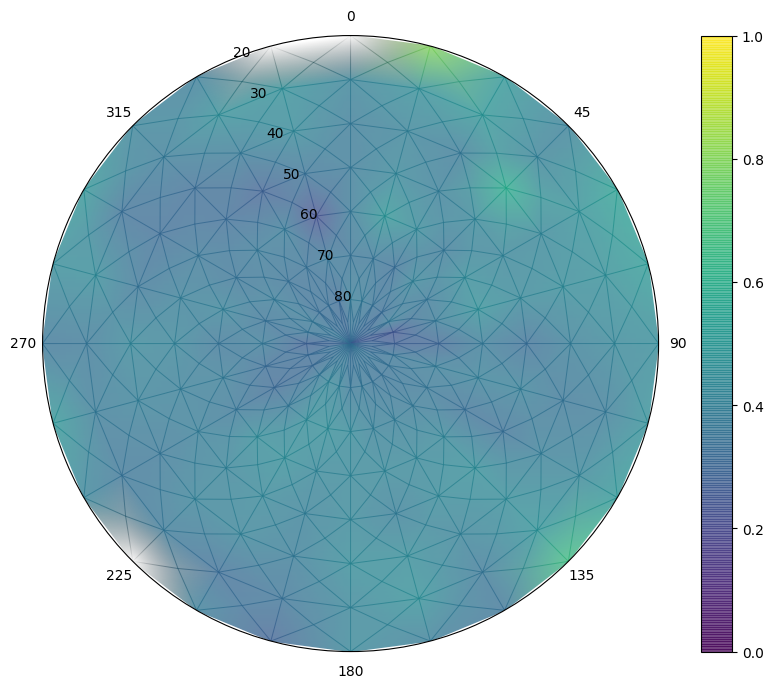

In [37]:
# Removing L5 from the DME air to ground
ChanIndx = notl5
if len(ChanIndx) != 0:


    SpecMaster = MyMaster.sum(dim = ['time','baseline'])
    SpecMaster = SpecMaster[ChanIndx].sum(dim = ['frequency'])

    SpecCounter = MyCounter.sum(dim = ['time','baseline'])
    SpecCounter = SpecCounter[ChanIndx].sum(dim = ['frequency'])

    SpecProb = SpecMaster.astype(float)/SpecCounter.astype(float)
    SpecProb = SpecProb.persist()

    Mydata = SpecProb
    
    MyPLot(AzProb,ElProb,Mydata)
else:
    print("Something went wrong in Frequency selection")

### Time 

## GPS sattellite

In [38]:
# These are the central frequency
L1 = np.arange(1575.42-(15.345*0.5),1575.42+(15.345*0.5))
L2 = np.arange(1227.6-(11.*0.5),1227.6+(11.*0.5))
L3 = np.arange(1381.05-(10.23*0.5),1381.05+(10.23*0.5))
L4 = np.arange(1379.91-(10.23*0.5),1379.91+(10.23*0.5))
L5 = np.arange(1176.45-(12.5*0.5),1176.45+(12.5*0.5))

### Dircetion

/home/isaac/.local/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


(8, 24)


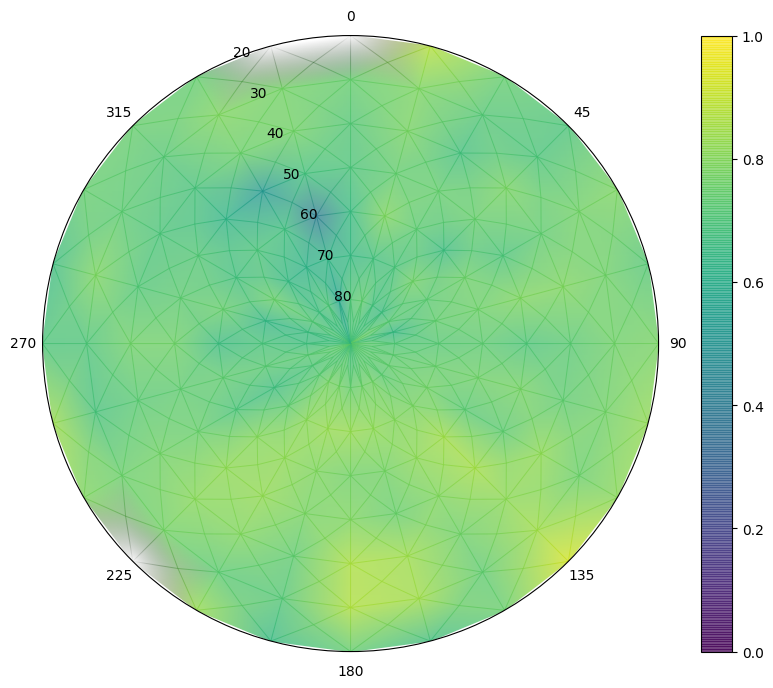

In [39]:
FreqLo = L1[0]
FreqHi = L1[-1]
ChanIndx = np.where((MyMeanFreqProb.frequency.frequency >= FreqLo*1.e6) & 
                    (MyMeanFreqProb.frequency.frequency <= FreqHi*1.e6))[0]

if len(ChanIndx) != 0:


    SpecMaster = MyMaster.sum(dim = ['time','baseline'])
    SpecMaster = SpecMaster[ChanIndx].sum(dim = ['frequency'])

    SpecCounter = MyCounter.sum(dim = ['time','baseline'])
    SpecCounter = SpecCounter[ChanIndx].sum(dim = ['frequency'])

    SpecProb = SpecMaster.astype(float)/SpecCounter.astype(float)
    SpecProb = SpecProb.persist()

    Mydata = SpecProb
    
    MyPLot(AzProb,ElProb,Mydata)
else:
    print("Something went wrong in Frequency selection")

/home/isaac/.local/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


(8, 24)


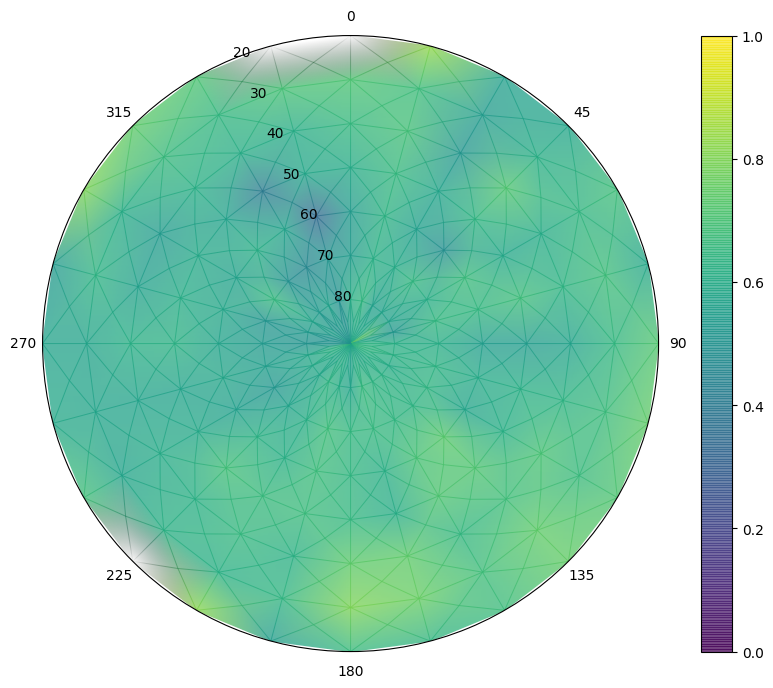

In [40]:
FreqLo = L2[0]
FreqHi = L2[-1]
ChanIndx = np.where((MyMeanFreqProb.frequency.frequency >= FreqLo*1.e6) & 
                    (MyMeanFreqProb.frequency.frequency <= FreqHi*1.e6))[0]

if len(ChanIndx) != 0:


    SpecMaster = MyMaster.sum(dim = ['time','baseline'])
    SpecMaster = SpecMaster[ChanIndx].sum(dim = ['frequency'])

    SpecCounter = MyCounter.sum(dim = ['time','baseline'])
    SpecCounter = SpecCounter[ChanIndx].sum(dim = ['frequency'])

    SpecProb = SpecMaster.astype(float)/SpecCounter.astype(float)
    SpecProb = SpecProb.persist()

    Mydata = SpecProb
    
    MyPLot(AzProb,ElProb,Mydata)
else:
    print("Something went wrong in Frequency selection")

/home/isaac/.local/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


(8, 24)


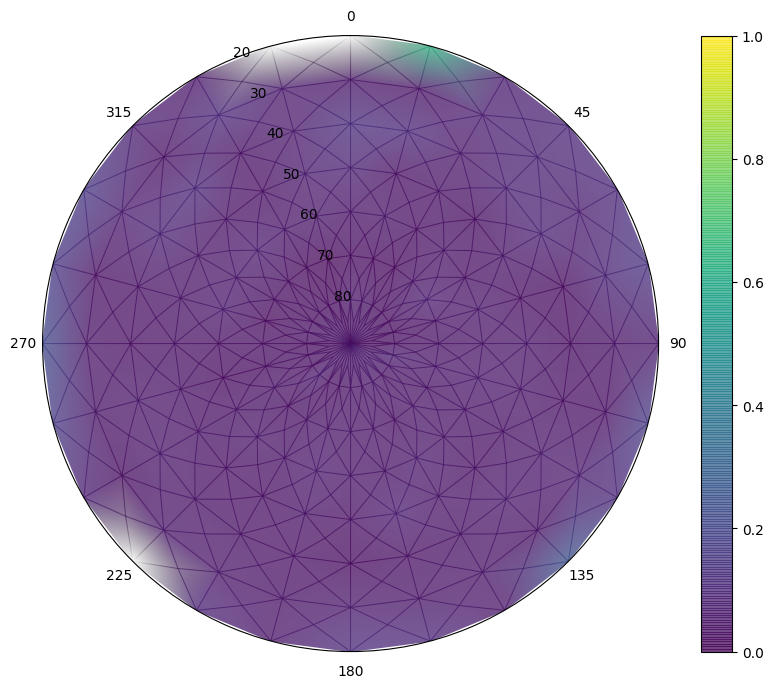

In [41]:
FreqLo = L3[0]
FreqHi = L3[-1]
ChanIndx = np.where((MyMeanFreqProb.frequency.frequency >= FreqLo*1.e6) & 
                    (MyMeanFreqProb.frequency.frequency <= FreqHi*1.e6))[0]

if len(ChanIndx) != 0:


    SpecMaster = MyMaster.sum(dim = ['time','baseline'])
    SpecMaster = SpecMaster[ChanIndx].sum(dim = ['frequency'])

    SpecCounter = MyCounter.sum(dim = ['time','baseline'])
    SpecCounter = SpecCounter[ChanIndx].sum(dim = ['frequency'])

    SpecProb = SpecMaster.astype(float)/SpecCounter.astype(float)
    SpecProb = SpecProb.persist()

    Mydata = SpecProb
    
    MyPLot(AzProb,ElProb,Mydata)
else:
    print("Something went wrong in Frequency selection")

/home/isaac/.local/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


(8, 24)


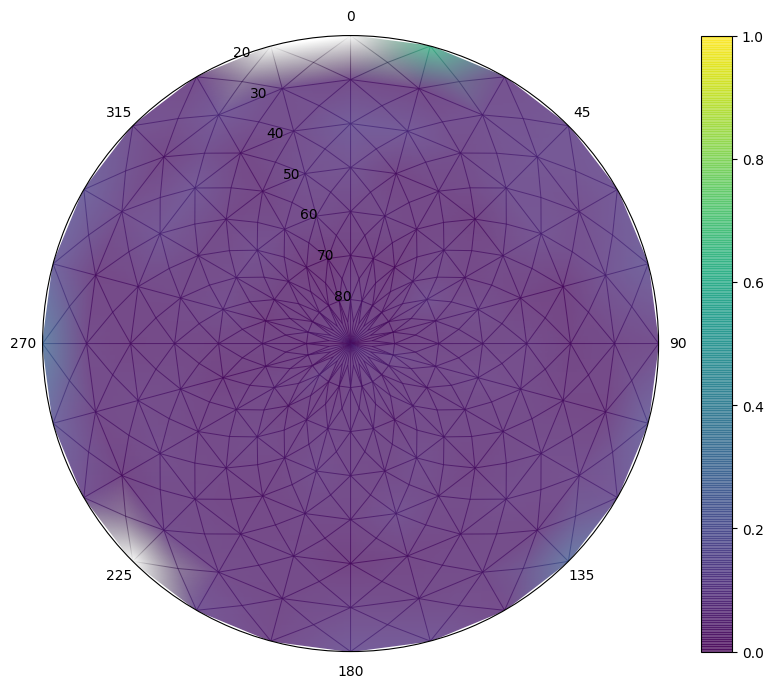

In [42]:
FreqLo = L4[0]
FreqHi = L4[-1]
ChanIndx = np.where((MyMeanFreqProb.frequency.frequency >= FreqLo*1.e6) & 
                    (MyMeanFreqProb.frequency.frequency <= FreqHi*1.e6))[0]

if len(ChanIndx) != 0:


    SpecMaster = MyMaster.sum(dim = ['time','baseline'])
    SpecMaster = SpecMaster[ChanIndx].sum(dim = ['frequency'])

    SpecCounter = MyCounter.sum(dim = ['time','baseline'])
    SpecCounter = SpecCounter[ChanIndx].sum(dim = ['frequency'])

    SpecProb = SpecMaster.astype(float)/SpecCounter.astype(float)
    SpecProb = SpecProb.persist()

    Mydata = SpecProb
    
    MyPLot(AzProb,ElProb,Mydata)
else:
    print("Something went wrong in Frequency selection")

/home/isaac/.local/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


(8, 24)


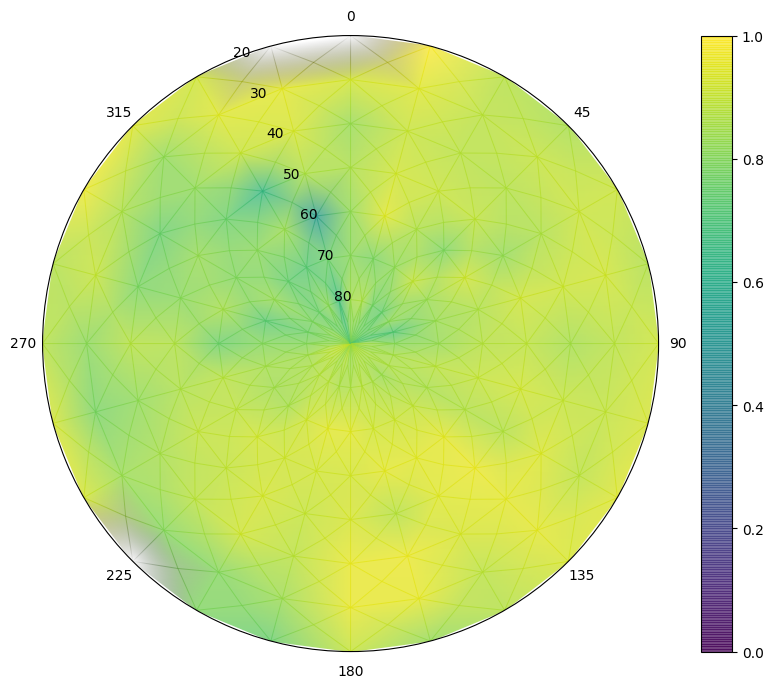

In [43]:
FreqLo = L5[0]
FreqHi = L5[-1]
ChanIndx = np.where((MyMeanFreqProb.frequency.frequency >= FreqLo*1.e6) & 
                    (MyMeanFreqProb.frequency.frequency <= FreqHi*1.e6))[0]

if len(ChanIndx) != 0:


    SpecMaster = MyMaster.sum(dim = ['time','baseline'])
    SpecMaster = SpecMaster[ChanIndx].sum(dim = ['frequency'])

    SpecCounter = MyCounter.sum(dim = ['time','baseline'])
    SpecCounter = SpecCounter[ChanIndx].sum(dim = ['frequency'])

    SpecProb = SpecMaster.astype(float)/SpecCounter.astype(float)
    SpecProb = SpecProb.persist()

    Mydata = SpecProb
    
    MyPLot(AzProb,ElProb,Mydata)
else:
    print("Something went wrong in Frequency selection")

/home/isaac/.local/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


(8, 24)


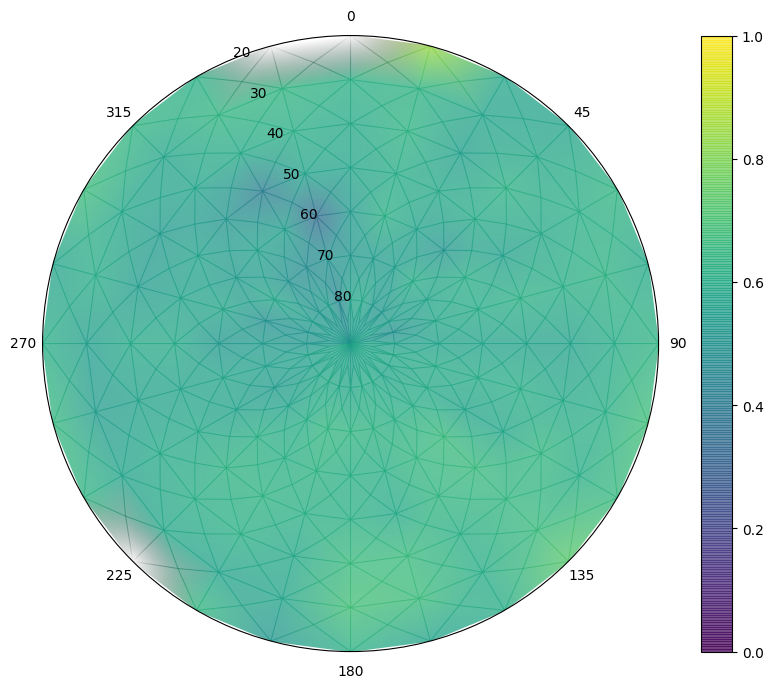

In [44]:
# Total of the GPS
ChanIndx = np.where((MyMeanFreqProb.frequency.frequency >= L1[0]*1.e6) & 
                    (MyMeanFreqProb.frequency.frequency <= L1[-1]*1.e6) |
                    
                    (MyMeanFreqProb.frequency.frequency >= L2[0]*1.e6) & 
                    (MyMeanFreqProb.frequency.frequency <= L2[-1]*1.e6) |
                    
                    (MyMeanFreqProb.frequency.frequency >= L3[0]*1.e6) & 
                    (MyMeanFreqProb.frequency.frequency <= L3[-1]*1.e6) |
                    (MyMeanFreqProb.frequency.frequency >= L4[0]*1.e6) & 
                    (MyMeanFreqProb.frequency.frequency <= L4[-1]*1.e6) |
                    (MyMeanFreqProb.frequency.frequency >= L5[0]*1.e6) & 
                    (MyMeanFreqProb.frequency.frequency <= L5[-1]*1.e6))[0]

if len(ChanIndx) != 0:


    SpecMaster = MyMaster.sum(dim = ['time','baseline'])
    SpecMaster = SpecMaster[ChanIndx].sum(dim = ['frequency'])

    SpecCounter = MyCounter.sum(dim = ['time','baseline'])
    SpecCounter = SpecCounter[ChanIndx].sum(dim = ['frequency'])

    SpecProb = SpecMaster.astype(float)/SpecCounter.astype(float)
    SpecProb = SpecProb.persist()

    Mydata = SpecProb
    
    MyPLot(AzProb,ElProb,Mydata)
else:
    print("Something went wrong in Frequency selection")
    
    

In [56]:
l3 = np.where(((freq>=FreqLo)&(freq<=FreqHi)))[0]

idx1 = np.where(((freq>=1310)&(freq<=1490)))[0]
idx2 = np.where(((freq>=970)&(freq<=1080)))[0]
idx = np.append(idx2,idx1)

In [57]:
notl3 = []
for value in idx:
    if value not in l3:
        notl3.append(value)

## Clean Band

/home/isaac/.local/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


(8, 24)


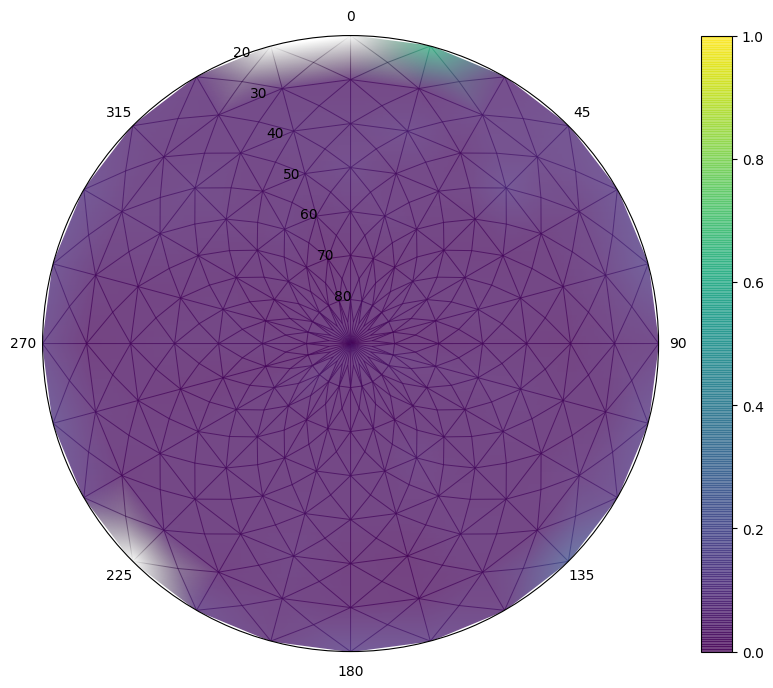

In [58]:
ChanIndx = notl3

if len(ChanIndx) != 0:


    SpecMaster = MyMaster.sum(dim = ['time','baseline'])
    SpecMaster = SpecMaster[ChanIndx].sum(dim = ['frequency'])

    SpecCounter = MyCounter.sum(dim = ['time','baseline'])
    SpecCounter = SpecCounter[ChanIndx].sum(dim = ['frequency'])

    SpecProb = SpecMaster.astype(float)/SpecCounter.astype(float)
    SpecProb = SpecProb.persist()

    MyPLot(AzProb,ElProb,SpecProb)
else:
    print("Something went wrong in Frequency selection")

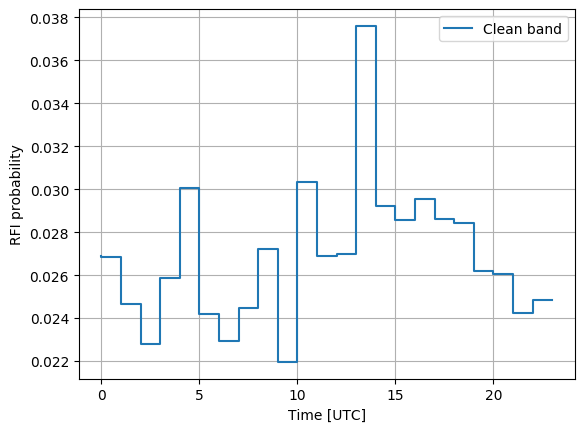

In [48]:
idx1 = np.where(((freq>=1310)&(freq<=1500)))[0]
idx2 = np.where(((freq>=970)&(freq<=1080)))[0]
idx = np.append(idx1,idx2)
tm = MyMaster[:,notl3].sum(dim=['frequency','baseline','azimuth','elevation'])
tc = MyCounter[:,notl3].sum(dim=['frequency','baseline','azimuth','elevation'])
p = tm.astype(float)/tc.astype(float)
p = p.values
plt.step(data.time.values,p,label='Clean band')
#print('Clean band',np.nanmean(p.values))
plt.legend()
plt.xlabel('Time [UTC]')
plt.ylabel('RFI probability')
plt.grid()
plt.show()

In [63]:
        
mon = ['May','June','July','August','September','October','November','December']

In [ ]:
print(mon[i-5]+' was added')